<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-notebook" data-toc-modified-id="Setup-notebook-1">Setup notebook</a></span></li><li><span><a href="#Align-and-filter-sequences" data-toc-modified-id="Align-and-filter-sequences-2">Align and filter sequences</a></span></li><li><span><a href="#Get-amino-acid-frequencies-and-other-relevant-information" data-toc-modified-id="Get-amino-acid-frequencies-and-other-relevant-information-3">Get amino-acid frequencies and other relevant information</a></span></li><li><span><a href="#Examine-sites-of-strong-immune-selection" data-toc-modified-id="Examine-sites-of-strong-immune-selection-4">Examine sites of strong immune selection</a></span></li></ul></div>

## Setup notebook
Import Python modules:

In [1]:
import collections
import gzip
import multiprocessing
import os
import re
import subprocess
import warnings

import Bio.SeqIO
import Bio.SeqRecord

from IPython.display import display, HTML

import matplotlib.pyplot as plt

import pandas as pd

from plotnine import *

import yaml

import dms_tools2
from dms_tools2 import AAS
from dms_tools2.ipython_utils import showPDF
from dms_tools2.plot import COLOR_BLIND_PALETTE_GRAY as PALETTE
print(f"Using dms_tools2 version {dms_tools2.__version__}")

Using dms_tools2 version 2.4.12


Filter warnings that clutter output:

In [2]:
warnings.simplefilter('ignore')

Read configuration:

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Get output directory and create if needed:

In [4]:
resultsdir = config['natseqs_dir']
os.makedirs(resultsdir, exist_ok=True)

CPUs to use:

In [5]:
ncpus = min(config['ncpus'], multiprocessing.cpu_count())

## Align and filter sequences
Read all of the natural sequences and add the reference sequence (the HA used in deep mutational scanning):

In [6]:
print(f"Processing sequences from {config['natseqs']}")
with gzip.open(config['natseqs'], 'rt') as f:
    seqs = list(Bio.SeqIO.parse(f, 'fasta'))
print(f"There are {len(seqs)} sequences.")

print(f"Adding reference sequence in {config['refseq']}")
refseq = Bio.SeqIO.read(config['refseq'], 'fasta')
seqs.append(refseq)

Processing sequences from data/human_H3N2_HA_2007-2018.fasta.gz
There are 19094 sequences.
Adding reference sequence in data/Perth09_HA_reference.fa


Use [phydms_prepalignment](http://jbloomlab.github.io/phydms/phydms_prepalignment.html) to align the coding sequences from the proteins, only keeping sequences that are unique at the protein level.
We also only keep sequences with $\ge$92% identity with the reference sequence, as this appears to be a good cutoff between true human H3N2 from this timeframe and mis-annotated sequences or ones from non-human H3 lineages:

In [7]:
print('Using following version of phydms:\n' +
      subprocess.check_output(['phydms_prepalignment', '--version']).decode('utf-8'))

inseqsfile = os.path.join(resultsdir, 'all_seqs.fasta')
Bio.SeqIO.write(seqs, inseqsfile, 'fasta')

alignmentfile = os.path.join(resultsdir, 'all_alignment.fasta')

if config['use_existing'] == 'yes' and os.path.isfile(alignmentfile):
    print(f"Using existing alignment in {alignmentfile}")
else:
    print(f"Building alignment and writing to {alignmentfile}...")
    _ = subprocess.check_call([
        'phydms_prepalignment',
        inseqsfile,
        alignmentfile,
        refseq.name,
        '--minuniqueness', '1',
        '--minidentity', '0.92',
        ])
    print("Bulding of alignment complete.")

Using following version of phydms:
phydms_prepalignment 2.3.1

Using existing alignment in results/natseqs/all_alignment.fasta


Look at plot showing divergence from "reference" seqeuence:

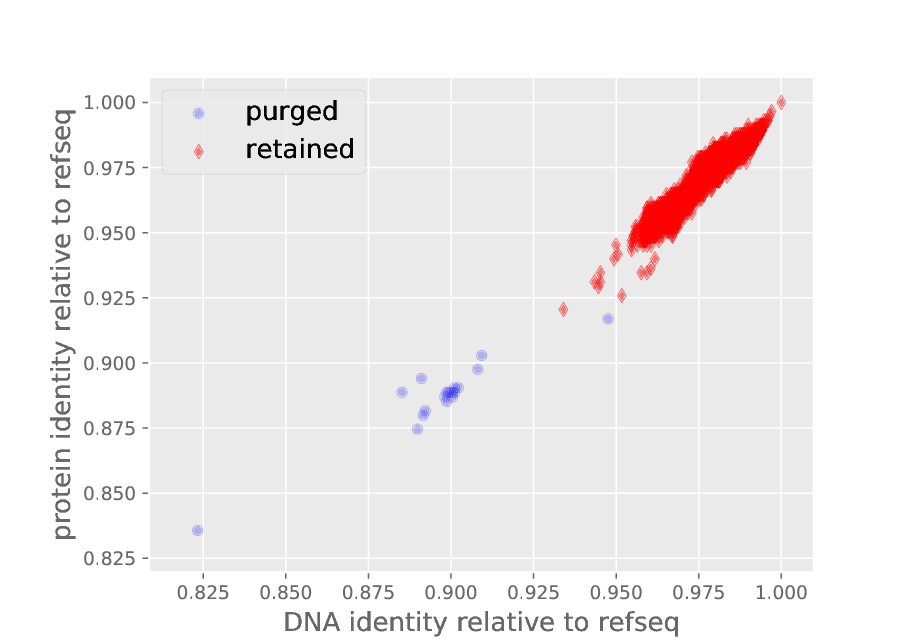

In [8]:
showPDF(os.path.splitext(alignmentfile)[0] + '.pdf')

Read alignment as proteins:

In [9]:
alignment = [Bio.SeqRecord.SeqRecord(seq.seq.translate(gap='-'), name=seq.name)
             for seq in Bio.SeqIO.parse(alignmentfile, 'fasta')
             if seq.name != refseq.name]
refprot = refseq.seq.translate(to_stop=True)
assert all(len(refprot) == len(seq) for seq in alignment)

print(f"Read all {len(alignment)} aligned proteins.")

Read all 5382 aligned proteins.


## Get amino-acid frequencies and other relevant information
Get amino-acid frequencies at each site for each year, breaking into 6-month intervals.

First, we partition sequences into these 6-month intervals:

In [10]:
unmatched = 0
alignment_by_year = collections.defaultdict(list)
for seq in alignment:
    datematch = re.search('_(?P<year>\d{4})/(?P<month>\d{1,2})/\d*_HA$', seq.name)
    if not datematch:
        unmatched += 1
    else:
        year = int(datematch.group('year'))
        month = int(datematch.group('month'))
        if 1 <= month <= 3:
            year = year
        elif 3 < month <= 9:
            year = year + 0.5
        elif 9 < month <= 12:
            year = year + 1
        else:
            raise ValueError('invalid month')
        alignment_by_year[year].append(str(seq.seq))

print('Here are number of sequences in each half-year:')
display(HTML(pd.DataFrame.from_records([(year, len(seqs)) for 
                                        year, seqs in alignment_by_year.items()],
                                       columns=['year', 'nsequences'])
             .sort_values('year')
             .to_html(index=False)
             ))

Here are number of sequences in each half-year:


year,nsequences
2007.0,85
2007.5,67
2008.0,111
2008.5,15
2009.0,76
2009.5,158
2010.0,27
2010.5,105
2011.0,260
2011.5,98


Build up data frame giving amino-acid counts at each site in each year, then compute frequencies and add site numbers in H3 numbering:

In [11]:
aafreqs_df = []
for year, year_alignment in alignment_by_year.items():
    for r, wt in enumerate(refprot):
        counts = collections.Counter([seq[r] for seq in year_alignment])
        aafreqs_df.append(
            pd.DataFrame({
                'year': year,
                'isite': r,
                'wildtype': wt,
                'mutation': [tup[0] for tup in sorted(counts.items())],
                'natural_count': [tup[1] for tup in sorted(counts.items())],
                })
            .assign(natural_frequency=lambda x: x['natural_count'] / len(year_alignment)) 
            )

aafreqs_df = pd.concat(aafreqs_df)

print(f"Adding H3 site numbering from {config['renumbering_scheme']}")

aafreqs_df = aafreqs_df.merge(
                pd.read_csv(config['renumbering_scheme'])
                .rename(columns={'original': 'isite', 'new': 'site'})
                .assign(isite=lambda x: x['isite'] - 1)
                )

Adding H3 site numbering from data/H3renumbering_scheme.csv


Here are what the first few lines of this data frame look like:

In [12]:
display(HTML(aafreqs_df.head().to_html(index=False)))

year,isite,wildtype,mutation,natural_count,natural_frequency,site
2017.0,0,M,M,731,1.0,-16
2014.0,0,M,M,161,1.0,-16
2017.5,0,M,M,187,1.0,-16
2013.0,0,M,M,500,1.0,-16
2011.0,0,M,M,260,1.0,-16


Now write this amino-acid frequency data frame to a file:

In [13]:
aafreqs_file = os.path.join(resultsdir, 'aafreqs.csv')
print(f"Writing amino-acid frequencies to {aafreqs_file}")
aafreqs_df.to_csv(aafreqs_file, index=False)

Writing amino-acid frequencies to results/natseqs/aafreqs.csv


## Examine sites of strong immune selection
Now we examine the amino-acid frequency changes at sites of strong immune selection.

First, we merge the amino-acid frequencies with the data frame containing the immune-selection values.
We keep only sites of major selection from human sera, which we define as:

 - being significanly selected in either the "VIDD sera" or "Hensley sera" set.
 - being "significant" sites according to the criterion used when analyzing the mutational antigenic profiling, which means that they have a value of `True` in the *zoom_site* column.
 
We also only keep amino acids at each site that have frequencies that exceed 5% in at least one year, and the re-normalize the frequencies for each site / year to sum to one:

In [14]:
sel_df_file = os.path.join(config['avgdiffseldir'], 'avg_sel_tidy.csv')
print(f"Merging with selection values in {sel_df_file}")
sel_df = pd.read_csv(sel_df_file, low_memory=False)

# add immune selection values and get sites of major selection
df = (pd.merge(aafreqs_df, sel_df)
      .query('serum_group in ["Hensley_sera", "VIDD_sera"]')
      .query('zoom_site')
      [['year', 'site', 'mutation', 'natural_frequency']]
      .drop_duplicates()
      .rename(columns={'mutation': 'amino acid'})
      )

# subset to amino acids with high natural frequencies in at least one year
df = (df.merge(df
               .groupby(['site', 'amino acid'])
               ['natural_frequency']
               .max()
               .rename('max_freq')
               .reset_index()
               )
      .query('max_freq > 0.05')
      .drop(columns='max_freq')
      )

# re-normalize frequencies
df = (df.merge(df
               .groupby(['site', 'year'])
               ['natural_frequency']
               .sum()
               .rename('tot_freq')
               .reset_index()
               )
      .assign(natural_frequency=lambda x: x['natural_frequency'] / x['tot_freq'])
      .drop(columns='tot_freq')
      )

Merging with selection values in results/avgdiffsel/avg_sel_tidy.csv


Plot frequencies per year for these sites:

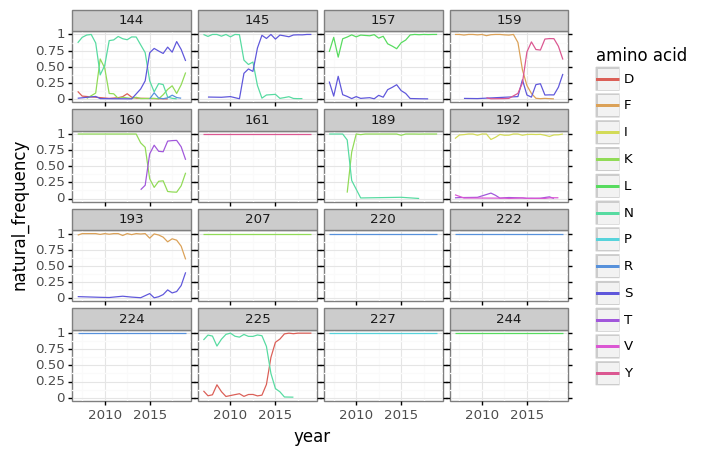

In [15]:
p = (
 ggplot(df, aes('year', 'natural_frequency', color='amino acid')) +
 geom_line() +
 facet_wrap('site')
 )

_ = p.draw()
plotfile = os.path.join(resultsdir, 'natural_freqs_plot.pdf')
p.save(plotfile)